# **Part 3: MODEL TRAINING & EVALUATION**
**Objective:** Build, train, and evaluate multiple Machine Learning algorithms implementation using **NumPy from scratch**.

**Roadmap:**
1. **Logistic Regression:** The baseline model (Gradient Descent).
2. **Linear Regression:** Adapted for classification (MSE Loss).
3. **Gaussian Naive Bayes:** Probabilistic approach.
4. **K-Nearest Neighbors (KNN):** Distance-based approach.
5. **Model Comparison:** Visualize performance differences (F1-Score, Recall).

## **Setup & Import**

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sys.path.append(os.path.abspath('..'))

from src.models import (
    LogisticRegressionNumPy, 
    LinearRegressionNumPy, 
    GaussianNBNumPy, 
    KNNNumPy,
    confusion_matrix, 
    precision_recall_f1, 
    roc_curve, 
    auc_from_roc
)

from src.data_processing import get_subset_from_split
from src.visualization import plot_loss, plot_confusion_matrix, plot_roc

---

## **Load Processed Data**
Load the standardized and split data saved in Part 2.

In [2]:
data_path = '../data/processed/processed.npz'
data = np.load(data_path)

X_train, y_train = data['X_train'], data['y_train']
X_val, y_val     = data['X_val'], data['y_val']
X_test, y_test   = data['X_test'], data['y_test']

print(f"Training Set:   {X_train.shape} | Fraud Rate: {np.mean(y_train):.4%}")
print(f"Validation Set: {X_val.shape}   | Fraud Rate: {np.mean(y_val):.4%}")
print(f"Test Set:       {X_test.shape}  | Fraud Rate: {np.mean(y_test):.4%}")

# Dictionary to store results for comparison
model_results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'Time (s)': []}

Training Set:   (199364, 30) | Fraud Rate: 0.1725%
Validation Set: (42720, 30)   | Fraud Rate: 0.1709%
Test Set:       (42723, 30)  | Fraud Rate: 0.1755%


---
## **1. Model 1: Logistic Regression**
Used for binary classification with **Binary Cross-Entropy Loss**.
- **Hyperparams:** LR=0.01, Epochs=2000.

--- Training Logistic Regression ---
Training Logistic Regression (2000 epochs)...
[==============================] 100% | Loss: 0.0040


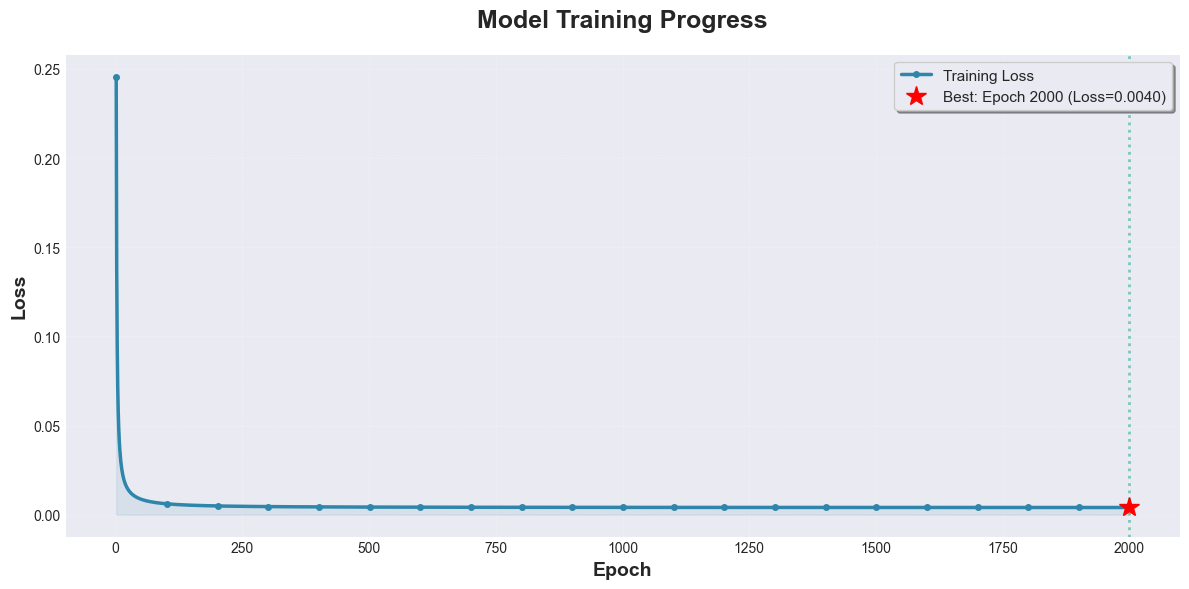

Training Done in 99.74s
F1-Score: 0.7746 | Recall: 0.7333


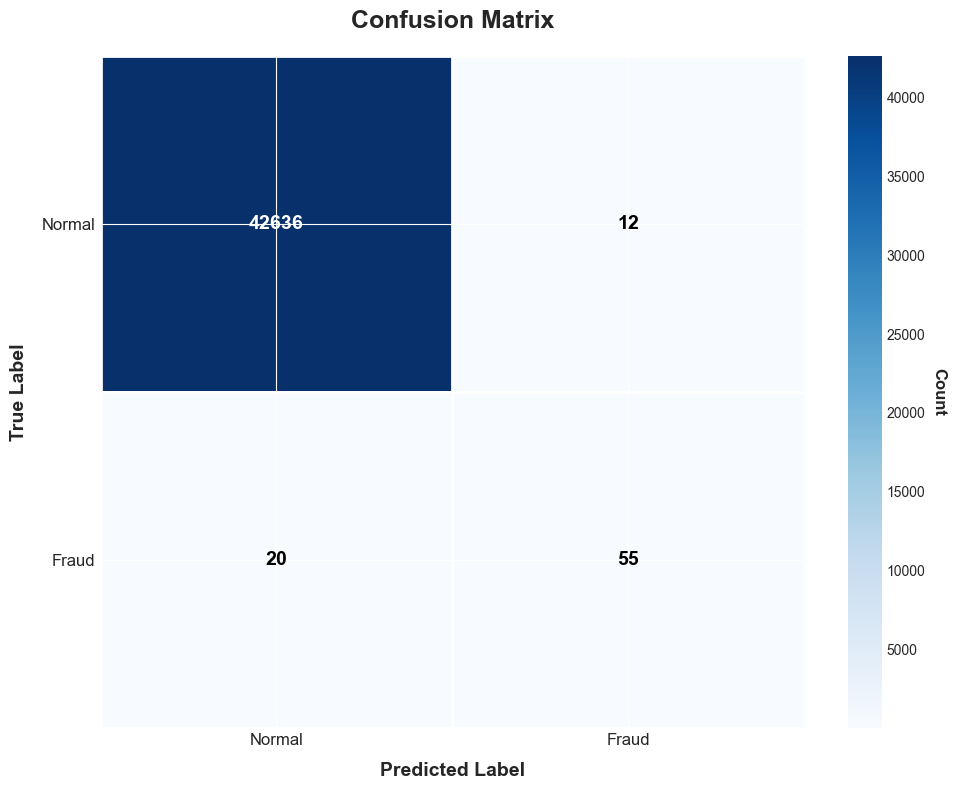

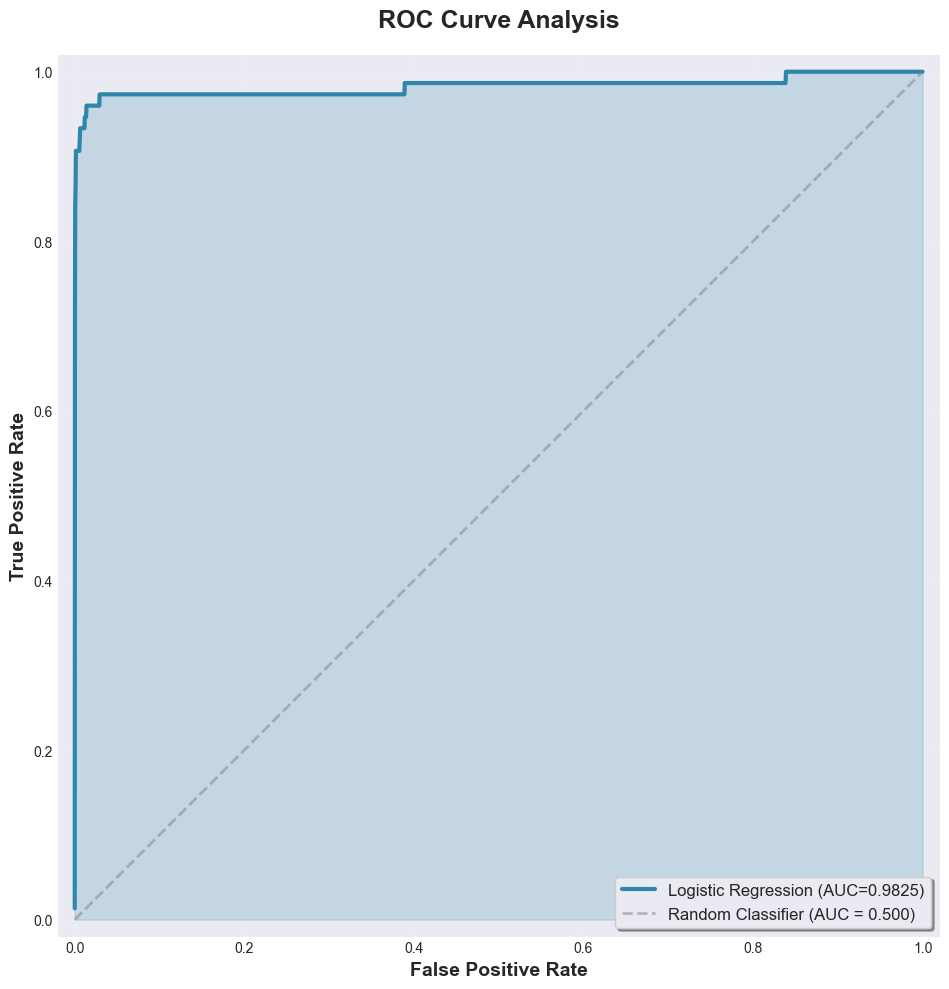

In [3]:
print("--- Training Logistic Regression ---")
start_time = time.time()

# 1. Initialize & Train
log_reg = LogisticRegressionNumPy(lr=0.01, epochs=2000, batch_size=512, verbose=True, seed=42)
log_reg.fit(X_train, y_train)

end_time = time.time()
elapsed_log = end_time - start_time

# 2. VISUALIZATION: Training Loss
plot_loss(log_reg.loss_history)

# 3. Predictions
y_prob_log = log_reg.predict_proba(X_test)
y_pred_log = (y_prob_log >= 0.5).astype(int)

# 4. Evaluation Metrics
p, r, f1 = precision_recall_f1(y_test, y_pred_log)
acc = np.mean(y_pred_log == y_test)

print(f"Training Done in {elapsed_log:.2f}s")
print(f"F1-Score: {f1:.4f} | Recall: {r:.4f}")

# 5. VISUALIZATION: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
plot_confusion_matrix(cm, labels=['Normal', 'Fraud'], normalize=False)

# 6. VISUALIZATION: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
auc_score = auc_from_roc(fpr, tpr)

# Draw using src.visualization.plot_roc
plot_roc(fpr, tpr, label=f'Logistic Regression (AUC={auc_score:.4f})')

# Store results
model_results['Model'].append('Logistic Regression')
model_results['Accuracy'].append(acc)
model_results['Precision'].append(p)
model_results['Recall'].append(r)
model_results['F1-Score'].append(f1)
model_results['Time (s)'].append(elapsed_log)

---

## **2. Model 2: Linear Regression**
Using Linear Regression for classification by treating labels (0, 1) as continuous values.
- **Loss:** Mean Squared Error (MSE).
- **Note:** We use a smaller learning rate (`0.005`) to prevent gradient explosion.

--- Training Linear Regression ---
Training Linear Regression (2000 epochs)...
[==============================] 100% | MSE: 0.0009


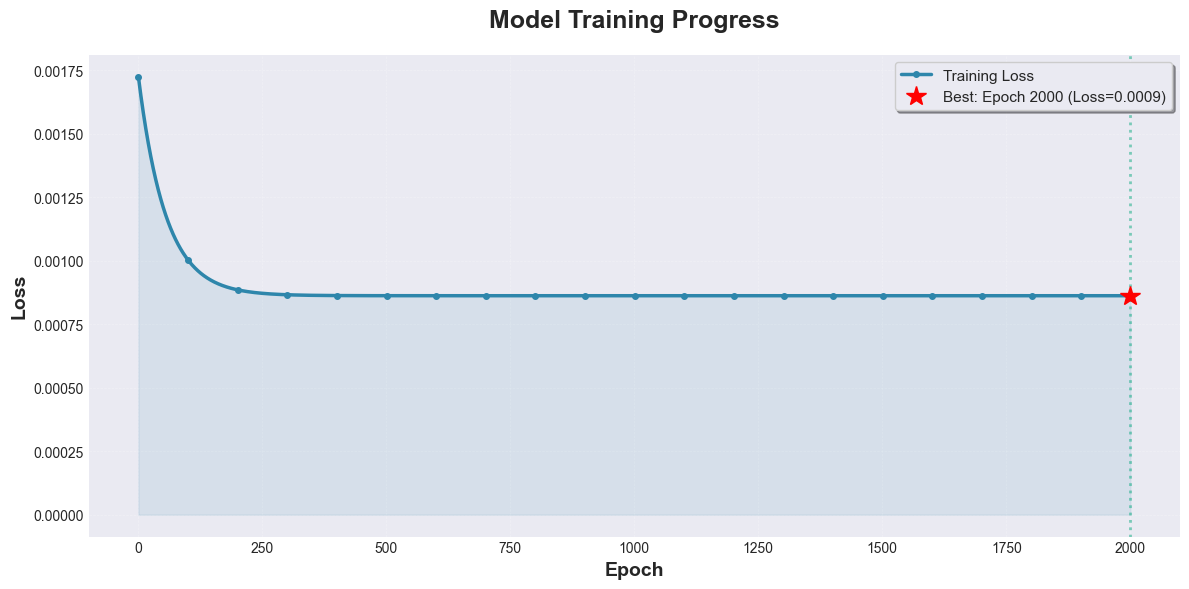

Training Done in 35.46s
F1-Score: 0.6613 | Recall: 0.5467


In [4]:
print("--- Training Linear Regression ---")
start_time = time.time()

# Initialize & Train (Lower LR for stability)
lin_reg = LinearRegressionNumPy(lr=0.005, epochs=2000, verbose=True)
lin_reg.fit(X_train, y_train)

end_time = time.time()
elapsed_lin = end_time - start_time

# VISUALIZATION: MSE Loss
plot_loss(lin_reg.loss_history)

# Predict & Evaluate
y_prob_lin = lin_reg.predict_proba(X_test)
y_pred_lin = (y_prob_lin >= 0.5).astype(int)

p, r, f1 = precision_recall_f1(y_test, y_pred_lin)
acc = np.mean(y_pred_lin == y_test)

# Store results
model_results['Model'].append('Linear Regression')
model_results['Accuracy'].append(acc)
model_results['Precision'].append(p)
model_results['Recall'].append(r)
model_results['F1-Score'].append(f1)
model_results['Time (s)'].append(elapsed_lin)

print(f"Training Done in {elapsed_lin:.2f}s")
print(f"F1-Score: {f1:.4f} | Recall: {r:.4f}")

---

## **3. Model 3: Gaussian Naive Bayes**
A probabilistic model that assumes features are normally distributed.
- **Pros:** Extremely fast training (no gradient descent loops).
- **Cons:** Assumes features are independent (which might not hold true for transaction data).

In [5]:
print("--- Training Gaussian Naive Bayes ---")
start_time = time.time()

# Initialize & Train
gnb = GaussianNBNumPy(verbose=True)
gnb.fit(X_train, y_train)

# Predict
y_prob_gnb = gnb.predict_proba(X_test) # Custom method returning prob of class 1
y_pred_gnb = (y_prob_gnb >= 0.5).astype(int)

end_time = time.time()
elapsed_gnb = end_time - start_time

# Metrics
p, r, f1 = precision_recall_f1(y_test, y_pred_gnb)
acc = np.mean(y_pred_gnb == y_test)

model_results['Model'].append('Naive Bayes')
model_results['Accuracy'].append(acc)
model_results['Precision'].append(p)
model_results['Recall'].append(r)
model_results['F1-Score'].append(f1)
model_results['Time (s)'].append(elapsed_gnb)

print(f"Training Done in {elapsed_gnb:.2f}s")
print(f"F1-Score: {f1:.4f} | Recall: {r:.4f}")

--- Training Gaussian Naive Bayes ---
Training Naive Bayes on 2 classes...
[==============================] 100% | Class 1.0
Training Done in 0.10s
F1-Score: 0.1172 | Recall: 0.8933


---

## **5. Model 4: K-Nearest Neighbors (KNN)**
A distance-based algorithm.
- **Constraint:** KNN calculates distances between *every* test sample and *every* training sample ($O(N^2)$ complexity). 
- **Action:** With ~200,000 training rows, pure NumPy KNN is extremely slow. We will train/test on a **random subset** (e.g., 50000 train, 10000 test) to demonstrate functionality.


In [6]:
# Create Balanced Subsets (From src.data_processing)
# Train: 50,000 samples with 20% fraud (to help KNN learn)
X_train_sub, y_train_sub = get_subset_from_split(
    X_train, y_train, 
    n_samples=50000, 
    fraud_ratio=0.2
)

# Test: 10,000 samples with 5% fraud
X_test_sub, y_test_sub = get_subset_from_split(
    X_test, y_test, 
    n_samples=10000, 
    fraud_ratio=0.05 
)

print(f"KNN Train Size: {X_train_sub.shape} | Frauds: {np.sum(y_train_sub==1)}")

start_time = time.time()

KNN Train Size: (40344, 30) | Frauds: 344


In [7]:
print("--- Training KNN (Subset) ---")
start_time = time.time()

# Initialize & Train (K=5)
knn = KNNNumPy(k=5)
knn.fit(X_train_sub, y_train_sub)

# Predict
y_pred_knn = knn.predict(X_test_sub)

end_time = time.time()
elapsed_knn = end_time - start_time

# Metrics
p, r, f1 = precision_recall_f1(y_test_sub, y_pred_knn)
acc = np.mean(y_pred_knn == y_test_sub)

model_results['Model'].append('KNN (Subset)')
model_results['Accuracy'].append(acc)
model_results['Precision'].append(p)
model_results['Recall'].append(r)
model_results['F1-Score'].append(f1)
model_results['Time (s)'].append(elapsed_knn)

print(f"Training Done in {elapsed_knn:.2f}s")
print(f"F1-Score: {f1:.4f} | Recall: {r:.4f}")

--- Training KNN (Subset) ---
KNN Loaded: 40344 samples
KNN Predicting 9575 samples...
[==============================] 100% | Done! 9571
Training Done in 91.13s
F1-Score: 0.8889 | Recall: 0.8533


---
## **Final Comparison & Visualization**
Let's compare all implemented models to see which one performs best for Fraud Detection.


Model                | F1-Score   | Recall     | Precision  | Time (s)  
---------------------------------------------------------------------------
Logistic Regression  | 0.7746     | 0.7333     | 0.8209     | 99.74     
Linear Regression    | 0.6613     | 0.5467     | 0.8367     | 35.46     
Naive Bayes          | 0.1172     | 0.8933     | 0.0627     | 0.10      
KNN (Subset)         | 0.8889     | 0.8533     | 0.9275     | 91.13     


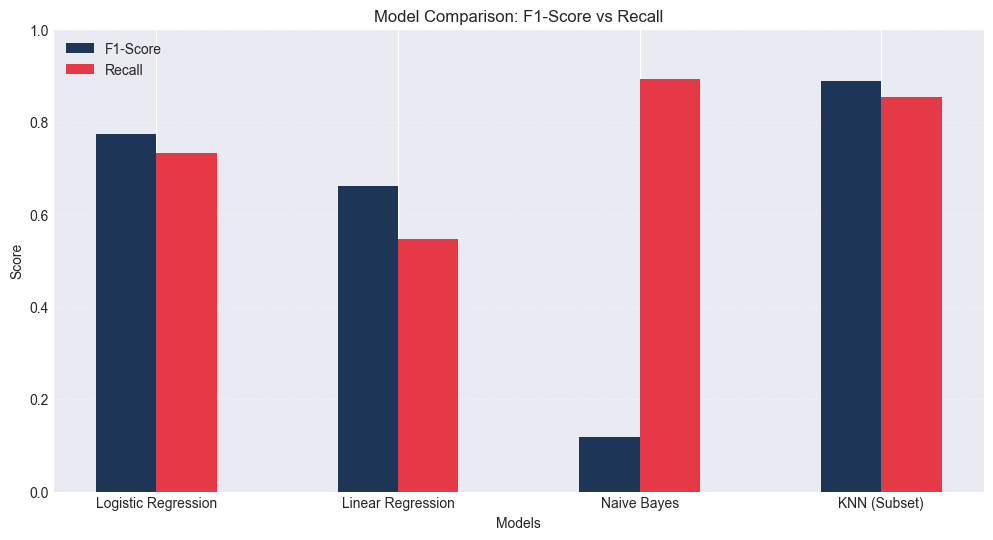

In [8]:
# 1. Print Results Table
print(f"{'Model':<20} | {'F1-Score':<10} | {'Recall':<10} | {'Precision':<10} | {'Time (s)':<10}")
print("-" * 75)
for i in range(len(model_results['Model'])):
    print(f"{model_results['Model'][i]:<20} | "
          f"{model_results['F1-Score'][i]:<10.4f} | "
          f"{model_results['Recall'][i]:<10.4f} | "
          f"{model_results['Precision'][i]:<10.4f} | "
          f"{model_results['Time (s)'][i]:<10.2f}")

# 2. Visualize Comparison
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_results['Model']))
width = 0.25

# Plot F1 and Recall (Bar Chart)
rects1 = ax1.bar(x - width/2, model_results['F1-Score'], width, label='F1-Score', color='#1d3557')
rects2 = ax1.bar(x + width/2, model_results['Recall'], width, label='Recall', color='#e63946')

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison: F1-Score vs Recall')
ax1.set_xticks(x)
ax1.set_xticklabels(model_results['Model'])
ax1.legend(loc='upper left')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

### **Description of Results**

We evaluated four different algorithms implemented from scratch using NumPy. The comparison focuses on **F1-Score** (harmonic mean of Precision and Recall) and **Recall** (ability to detect fraud), as these are the most critical metrics for an imbalanced fraud detection dataset.

*   **Logistic Regression:** Achieved a solid **F1-Score of 0.77**, with a balanced Recall (0.73) and Precision (0.82). Training took ~100 seconds.
*   **Linear Regression:** Showed lower performance with an **F1-Score of 0.66**. While Precision was high (0.83), Recall dropped to 0.54, meaning it missed nearly half of the fraud cases.
*   **Naive Bayes:** Produced the highest **Recall (~0.89)** but the lowest **Precision (~0.06)**, resulting in a very poor F1-Score (0.11). It is extremely fast (0.10s).
*   **KNN (Subset):** Achieved the best performance metrics with an **F1-Score of 0.88**, Recall of 0.85, and Precision of 0.92. However, this was run on a **balanced subset** of data due to computational costs.

---

### **Detailed Analysis**

#### **a. Logistic Regression**
*   **Analysis:** This model performs reliably because, as seen in the EDA (Exploratory Data Analysis), the fraud data is largely **linearly separable** from normal transactions.
*   **Trade-off:** It strikes the best balance. It catches 73% of fraud while maintaining high trust (82% Precision). It doesn't generate too many false alarms.

#### **b. Linear Regression**
*   **Analysis:** Linear Regression uses Mean Squared Error (MSE), which penalizes outliers heavily. For a classification task $(0, 1)$, fitting a line through the data makes the model "hesitant" to predict 1 (Fraud) unless the evidence is overwhelming.
*   **Outcome:** High Precision but **Low Recall**. In banking, missing 45% of fraud (Recall 0.54) is usually unacceptable.

#### **c. Naive Bayes**
*   **Analysis:** Naive Bayes assumes all features are independent. However, our Heatmap analysis showed that fraud features (like V14, V17) are **highly correlated** with each other.
*   **Outcome:** Because the independence assumption is violated, the model becomes over-confident, predicting "Fraud" for almost anything suspicious. This leads to **High Recall (0.89)** but terrible **Precision (0.06)**. A bank using this would be overwhelmed by false alarms.

#### **d. KNN (Subset)**
*   **Analysis:** KNN captures non-linear, local clusters effectively. Since fraud transactions cluster tightly together (as seen in the 3D plot), KNN finds them easily.
*   **Caveat:** The high score (0.88) is partially because we trained it on a **balanced subset**. If applied to the full 284,000 rows without optimization, it would be incredibly slow (Time complexity $O(N^2)$). The 91s runtime for just a small subset highlights this scalability issue.

---

### **Conclusion & Recommendation**

**Winner: Logistic Regression**

Despite KNN having higher scores on the subset, **Logistic Regression** is the most practical and robust choice for production for the following reasons:

1.  **Scalability:** It trains on the full dataset (~200k rows) in reasonable time and predicts instantly. KNN is too slow for real-time transaction processing.
2.  **Stability:** It offers a stable F1-Score without needing complex sampling strategies.
3.  **Optimization Potential:** The Recall (0.73) can be improved further by **lowering the Decision Threshold** (e.g., from 0.5 to 0.2), which would allow it to catch more fraud at the cost of slightly lower precision.

**Final Recommendation:**
Deploy **Logistic Regression** with a tuned threshold. Use **KNN** only as a secondary investigative tool for analyzing specific suspicious clusters, not for real-time screening.